In [21]:
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from deap import base, creator, tools
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

# Build LSTM model where only lstm_units2 is optimized

In [61]:
def build_lstm_model_ga(lstm_units1, lstm_units2, input_shape, dropout_rate=0.3, learning_rate=0.001, optimizer_type=0):
    """
    Builds a Sequential LSTM model with two stacked LSTM layers and dropout.

    Args:
        lstm_units1 (int): Number of units for the first LSTM layer.
        lstm_units2 (int): Number of units for the second LSTM layer.
        input_shape (tuple): Shape of the input sequences (sequence_length, num_features).
        dropout_rate (float): Dropout rate to apply after each LSTM layer (default 0.3).
        learning_rate (float): Learning rate for the optimizer (default 0.001).
        optimizer_type (int): 0 for Adam, 1 for RMSprop (default 0).

    Returns:
        tf.keras.Model: Compiled Keras Sequential model.
    """
    model = Sequential()
    
    # First LSTM layer - returns sequences for the next LSTM layer
    model.add(LSTM(units=lstm_units1, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(dropout_rate)) # Standard regularization

    # Second LSTM layer - does not return sequences as it's followed by a Dense layer
    model.add(LSTM(units=lstm_units2, return_sequences=False))
    model.add(Dropout(dropout_rate)) # Standard regularization

    # Output layer for regression (single output: RUL)
    model.add(Dense(1)) 

    # Optimizer selection
    optimizer = Adam(learning_rate=learning_rate) if optimizer_type == 0 else RMSprop(learning_rate=learning_rate)
    
    # Compile the model with Mean Squared Error (MSE) loss
    model.compile(loss='mse', optimizer=optimizer)
    
    return model

# Fitness function for optimizing lstm_units

In [62]:
def eval_lstm_fitness(individual, X_train, y_train, X_val, y_val, dropout_rate=0.3, learning_rate=0.001, optimizer_type=0):
    lstm_units1 = int(individual[0])
    lstm_units2 = int(individual[1])

    # Clamp to ensure valid range
    lstm_units1 = max(10, min(100, lstm_units1))
    lstm_units2 = max(10, min(100, lstm_units2))

    print(f"\nEvaluating LSTM1 = {lstm_units1}, LSTM2 = {lstm_units2}")

    model = build_lstm_model_ga(
        int(lstm_units2),int(lstm_units1), (X_train.shape[1], X_train.shape[2]), dropout_rate, learning_rate, optimizer_type
    )

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=0)

    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=460, batch_size=32, verbose=1, callbacks=[early_stopping])

    val_loss = np.min(history.history['val_loss'])
    regularization = 0.001 * (lstm_units1 + lstm_units2)
    fitness = 1 / (1 + np.sqrt(val_loss) + regularization)

    print(f"✅ Minimum Validation Loss: {val_loss:.4f}")
    print(f"✅ Fitness: {fitness:.6f} (Reg: {regularization:.4f})")

    return (fitness, val_loss)

# Configure Genetic Algorithm for LSTM optimization

In [24]:
def setup_ga_lstm():
    if not hasattr(creator, "FitnessMin"):
        creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    if not hasattr(creator, "Individual"):
        creator.create("Individual", list, fitness=creator.FitnessMin)

    toolbox = base.Toolbox()
    toolbox.register("lstm_units1", random.randint, 10, 100)
    toolbox.register("lstm_units2", random.randint, 10, 100)
    
    # Individual will now have 2 genes
    toolbox.register("individual", tools.initCycle, creator.Individual,
                     (toolbox.lstm_units1, toolbox.lstm_units2), n=1)
    
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("mate", tools.cxBlend, alpha=0.5)
    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=5, indpb=0.5)
    toolbox.register("select", tools.selTournament, tournsize=3)

    return toolbox

In [25]:
def run_ga_lstm(toolbox, X_train, y_train, X_val, y_val, dropout_rate=0.3, learning_rate=0.001, optimizer_type=0, population_size=10, generations=10):

    toolbox.register("evaluate", lambda ind: eval_lstm_fitness(
        ind, X_train, y_train, X_val, y_val,
        dropout_rate, learning_rate, optimizer_type
    ))

    pop = toolbox.population(n=population_size)
    loss_history = []

    global_best = None
    global_best_loss = float('inf')

    for gen in range(generations):
        print(f"\n--- Generation {gen + 1}/{generations} ---")

        offspring = list(map(toolbox.clone, toolbox.select(pop, len(pop))))

        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < 0.5:
                toolbox.mate(child1, child2)
                del child1.fitness.values, child2.fitness.values

        for mutant in offspring:
            if random.random() < 0.2:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        for ind in offspring:
            if not ind.fitness.valid:
                fitness, val_loss = toolbox.evaluate(ind)
                ind.fitness.values = (fitness,)
                ind.val_loss = val_loss

                if val_loss < global_best_loss:
                    global_best = creator.Individual(ind)
                    global_best_loss = val_loss

        pop[:] = offspring

        best_ind = tools.selBest(pop, 1)[0]
        best_loss = getattr(best_ind, 'val_loss', toolbox.evaluate(best_ind)[1])
        loss_history.append(best_loss)

        print(f"✅ Generation {gen + 1}: Best LSTM1 = {best_ind[0]}, LSTM2 = {best_ind[1]} | Val Loss = {best_loss:.4f}")

    return global_best, loss_history

In [27]:
def plot_ga_lstm_loss(loss_history):
    """ Plot evolution of validation loss over generations """
    plt.plot(range(1, len(loss_history) + 1), loss_history, marker='o', linestyle='-')
    plt.xlabel("Generations")
    plt.ylabel("Validation Loss")
    plt.title("LSTM Hyperparameter Optimization using GA")
    plt.show()

In [72]:
import pickle

def load_data():
    df = pd.read_csv("battery_data.csv")

    # Define features and target
    features = ["cycle", "ambient_temperature", "capacity", "voltage_measured", "current_measured",
                "temperature_measured", "current_load", "voltage_load", "time"]
    target = "RUL"

    selected_columns = features + [target]

    # Correlation heatmap
    corr_df = df[selected_columns]
    corr_matrix = corr_df.corr()

    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
    plt.title("Feature Correlation Heatmap with RUL")
    plt.show()

    # Sort data by time to ensure chronological order
    df_sorted = df.sort_values(by="time").reset_index(drop=True)

    # Extract features and target from sorted dataframe
    X = df_sorted[features].values
    y = df_sorted[target].values

    # ✅ Save scaler with all 9 features (including time)
    scaler_with_time = StandardScaler()
    scaler_with_time.fit(X)
    with open("scaler.pkl", "wb") as f:
        pickle.dump(scaler_with_time, f)

    # Separate time column (index 8)
    time_column = X[:, 8].reshape(-1, 1)
    X_wo_time = np.delete(X, 8, axis=1)

    # Train-test split (will maintain time order since already sorted)
    X_train_wo_time, X_test_wo_time, y_train, y_test, time_train, time_test = train_test_split(
        X_wo_time, y, time_column, test_size=0.2, shuffle=False  # ⛔ no shuffle!
    )

    # Scale without time
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_wo_time)
    X_test_scaled = scaler.transform(X_test_wo_time)

    # Reattach unscaled time column at the same index (position 8)
    X_train = np.insert(X_train_scaled, 8, time_train.reshape(-1), axis=1)
    X_test = np.insert(X_test_scaled, 8, time_test.reshape(-1), axis=1)

    # Reshape for LSTM or Conv1D input (samples, features, 1)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    return X_train, X_test, y_train, y_test


In [135]:
# Assuming load_data function is defined elsewhere and returns X_train, X_test, y_train, y_test
# For this function to run, ensure X_train and X_test are passed in their 3D (samples, features, 1) shape

def build_svr_model(X_train, X_test, y_train, y_test, mode='random', use_tqdm=True):
    # Reshape for scaling - SVR expects 2D input
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_test_flat = X_test.reshape(X_test.shape[0], -1)

    # Standard scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_flat)
    X_test_scaled = scaler.transform(X_test_flat)

    # Parameter grid with adjustments to reduce overfitting
    # Focus on larger epsilon and smaller C values
    param_grid = {
    'C': [5, 10, 20, 50],
    'gamma': ['scale', 0.0005, 0.001, 0.005],
    'epsilon': [0.08, 0.1, 0.12, 0.15]
    }

    # Choose search strategy
    if mode == 'grid':
        search = GridSearchCV(
            SVR(kernel='rbf'),
            param_grid=param_grid,
            cv=3,
            scoring='neg_mean_squared_error',
            verbose=10 if use_tqdm else 0,
            n_jobs=-1
        )
    elif mode == 'halving':
        search = HalvingGridSearchCV(
            SVR(kernel='rbf'),
            param_grid=param_grid,
            cv=3,
            scoring='neg_mean_squared_error',
            verbose=1,
            n_jobs=-1
        )
    else:  # Default to randomized
        search = RandomizedSearchCV(
            SVR(kernel='rbf'),
            param_distributions=param_grid,
            n_iter=20, # Increased n_iter to explore more combinations in the expanded grid
            cv=3,
            scoring='neg_mean_squared_error',
            verbose=10 if use_tqdm else 0,
            n_jobs=-1,
            random_state=42
        )

    # Fit model
    search.fit(X_train_scaled, y_train)
    best_svr = search.best_estimator_

    # Save best SVR model to a file
    with open("svr_model.pkl", "wb") as f:
        pickle.dump(best_svr, f)

    # Predictions
    y_train_pred = best_svr.predict(X_train_scaled)
    y_test_pred = best_svr.predict(X_test_scaled)

    # MSE
    svr_train_mse = mean_squared_error(y_train, y_train_pred)
    svr_test_mse = mean_squared_error(y_test, y_test_pred)

    # RMSE
    svr_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    svr_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

    # MAE
    svr_train_mae = mean_absolute_error(y_train, y_train_pred)
    svr_test_mae = mean_absolute_error(y_test, y_test_pred)

    # R² Score
    svr_train_r2 = r2_score(y_train, y_train_pred)
    svr_test_r2 = r2_score(y_test, y_test_pred)

    # Explained Variance Score
    svr_train_evs = explained_variance_score(y_train, y_train_pred)
    svr_test_evs = explained_variance_score(y_test, y_test_pred)

    # Output
    print(f"\n✅ Best Params: {search.best_params_}")
    print(f"\n📊 SVR Evaluation Metrics:")
    print(f"Train MSE : {svr_train_mse:.4f} | Test MSE : {svr_test_mse:.4f}")
    print(f"Train RMSE: {svr_train_rmse:.4f} | Test RMSE: {svr_test_rmse:.4f}")
    print(f"Train MAE : {svr_train_mae:.4f} | Test MAE : {svr_test_mae:.4f}")
    print(f"Train R²  : {svr_train_r2:.4f} | Test R²  : {svr_test_r2:.4f}")
    print(f"Train EVS : {svr_train_evs:.4f} | Test EVS : {svr_test_evs:.4f}")

    return best_svr

In [30]:
def get_predictions(lstm_model, svr_model, X_test):
    lstm_preds = lstm_model.predict(X_test).flatten()
    svr_preds = svr_model.predict(X_test.reshape(X_test.shape[0], -1))
    return lstm_preds, svr_preds

In [164]:
from sklearn.metrics import root_mean_squared_error

def eval_fitness(individual, lstm_preds, svr_preds, y_test):
    w = individual[0] # Optimize for a single weight 'w'
    final_preds = w * lstm_preds + (1 - w) * svr_preds # Enforce w1 + w2 = 1
    rmse = root_mean_squared_error(y_test, final_preds)
    return (1 / (1 + rmse),) # Minimize RMSE

In [165]:
def setup_ga():
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMax)

    toolbox = base.Toolbox()
    toolbox.register("attr_float", random.uniform, 0, 1) # w will be between 0 and 1
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, 1) # Only 1 gene
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    toolbox.register("mate", tools.cxBlend, alpha=0.5)
    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.2)
    toolbox.register("select", tools.selTournament, tournsize=3)

    return toolbox

In [166]:
def run_ga(toolbox, lstm_preds, svr_preds, y_test):
    toolbox.register("evaluate", lambda ind: eval_fitness(ind, lstm_preds, svr_preds, y_test))
    pop = toolbox.population(n=500)
    
    for gen in range(100):
        offspring = list(map(toolbox.clone, toolbox.select(pop, len(pop))))
        
        # Apply crossover and clip
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < 0.5:
                toolbox.mate(child1, child2)
                del child1.fitness.values, child2.fitness.values
                # Clip to [0,1]
                for i in range(len(child1)):
                    child1[i] = min(max(child1[i], 0.0), 1.0)
                for i in range(len(child2)):
                    child2[i] = min(max(child2[i], 0.0), 1.0)
        
        # Apply mutation and clip
        for mutant in offspring:
            if random.random() < 0.2:
                toolbox.mutate(mutant)
                del mutant.fitness.values
                # Clip to [0,1]
                for i in range(len(mutant)):
                    mutant[i] = min(max(mutant[i], 0.0), 1.0)
        
        # Evaluate new offspring
        fitnesses = list(map(toolbox.evaluate, offspring))
        for ind, fit in zip(offspring, fitnesses):
            ind.fitness.values = fit
        
        pop[:] = offspring  # Replace population

    return tools.selBest(pop, 1)[0]

In [34]:
def plot_rmse(rmse_value):
    plt.plot([1], [rmse_value], marker='o', linestyle='-')
    plt.xlabel("Generation")
    plt.ylabel("RMSE Score")
    plt.title("RMSE over Generations")
    plt.grid(True)
    plt.show()

In [35]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('LSTM Training vs. Validation Loss')
    plt.legend()
    plt.show()

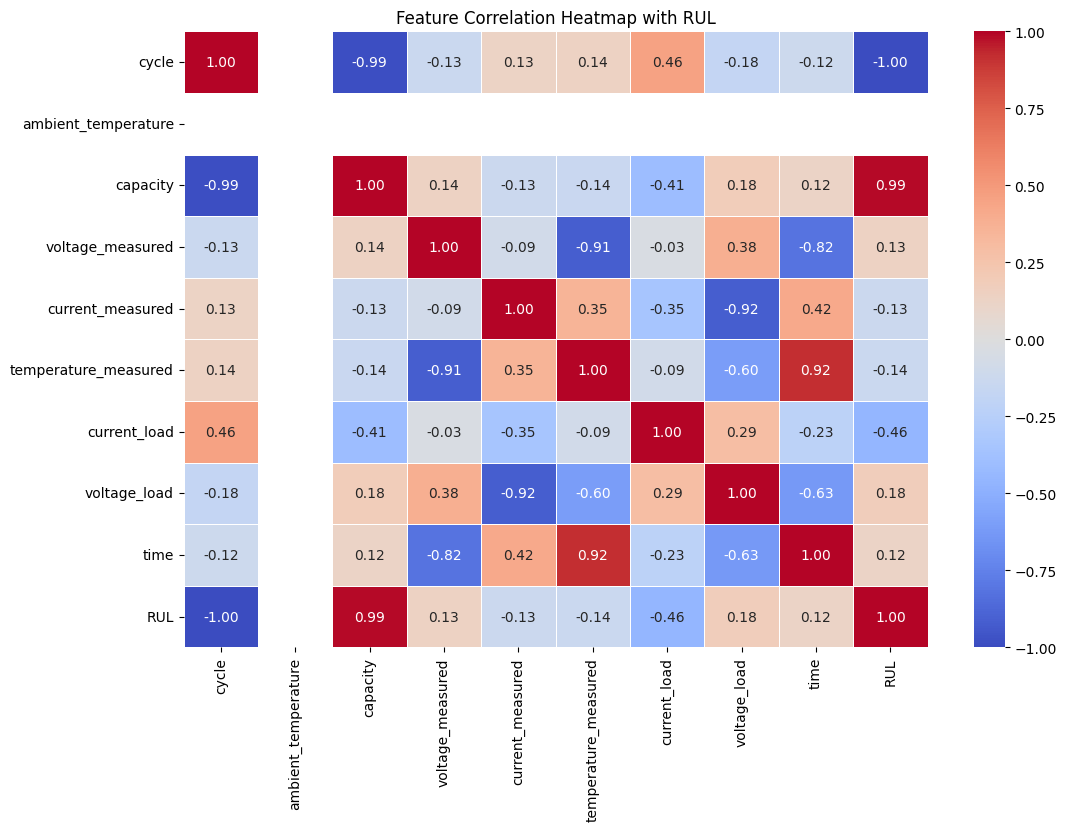

In [199]:
X_train, X_test, y_train, y_test = load_data()
X_train_, X_val, y_train_, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Run Genetic Algorithm for LSTM hyperparameter optimization

In [80]:
toolbox = setup_ga_lstm()

In [42]:
best_lstm_params, loss_history =run_ga_lstm(toolbox, X_train, y_train, X_val, y_val, population_size=10, generations=10)
print("Best LSTM Hyperparameters:", best_lstm_params)


--- Generation 1/10 ---

Evaluating LSTM1 = 77, LSTM2 = 73
Epoch 1/460
15/15 [==============================] - 4s 58ms/step - loss: 12275.1172 - val_loss: 12013.8232
Epoch 2/460
15/15 [==============================] - 0s 12ms/step - loss: 11275.8594 - val_loss: 10162.1279
Epoch 3/460
15/15 [==============================] - 0s 12ms/step - loss: 9795.9912 - val_loss: 9401.9619
Epoch 4/460
15/15 [==============================] - 0s 12ms/step - loss: 9253.2119 - val_loss: 9047.9053
Epoch 5/460
15/15 [==============================] - 0s 12ms/step - loss: 8929.8125 - val_loss: 8761.3457
Epoch 6/460
15/15 [==============================] - 0s 12ms/step - loss: 8685.5312 - val_loss: 8500.5195
Epoch 7/460
15/15 [==============================] - 0s 12ms/step - loss: 8407.0342 - val_loss: 8254.1055
Epoch 8/460
15/15 [==============================] - 0s 12ms/step - loss: 8160.4575 - val_loss: 8015.9917
Epoch 9/460
15/15 [==============================] - 0s 12ms/step - loss: 7921.1338 - va

# Train final optimized LSTM

In [81]:
best_lstm_model = build_lstm_model_ga(
    # lstm_units1=int(best_lstm_params[0]),
    # lstm_units2=int(best_lstm_params[1]),
    lstm_units1=93,
    lstm_units2=32,
    # lstm_units1=64,
    # lstm_units2=32,
    input_shape=(X_train.shape[1], X_train.shape[2]),
    # dropout_rate=0.3,
    learning_rate=0.001,
    optimizer_type=0
)

In [84]:
history = best_lstm_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=40, batch_size=32, verbose=1)
best_lstm_model.save("ltm_model.h5")

Epoch 1/40
1258/1258 [==============================] - 14s 12ms/step - loss: 54.3008 - val_loss: 2.7006
Epoch 2/40
1258/1258 [==============================] - 14s 12ms/step - loss: 53.0381 - val_loss: 1.2305
Epoch 3/40
1258/1258 [==============================] - 14s 12ms/step - loss: 54.1032 - val_loss: 0.6750
Epoch 4/40
1258/1258 [==============================] - 15s 12ms/step - loss: 52.5971 - val_loss: 0.5736
Epoch 5/40
1258/1258 [==============================] - 15s 12ms/step - loss: 51.6189 - val_loss: 0.9093
Epoch 6/40
1258/1258 [==============================] - 15s 12ms/step - loss: 52.0412 - val_loss: 0.7248
Epoch 7/40
1258/1258 [==============================] - 15s 12ms/step - loss: 50.7691 - val_loss: 1.0436
Epoch 8/40
1258/1258 [==============================] - 15s 12ms/step - loss: 50.2746 - val_loss: 1.4153
Epoch 9/40
1258/1258 [==============================] - 14s 11ms/step - loss: 49.3740 - val_loss: 2.9870
Epoch 10/40
1258/1258 [==============================] 

In [85]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# Predict on validation set
lstm_preds = best_lstm_model.predict(X_val)

# If y_val is scaled, remember to inverse transform y_pred and y_val accordingly

# Evaluation metrics
mse = mean_squared_error(y_val, lstm_preds)
rmse = np.sqrt(mean_squared_error(y_val.ravel(), lstm_preds.ravel()))
mae = mean_absolute_error(y_val, lstm_preds)
r2 = r2_score(y_val, lstm_preds)

print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R² Score: {r2:.4f}')


252/252 [==============================] - 3s 7ms/step
MSE: 0.2573
RMSE: 0.5072
MAE: 0.4032
R² Score: 0.9999


In [86]:
print(X_test.shape)
print(y_test.shape)
print(lstm_preds.shape)
# Also print the length of time_values after it's created
time_values = X_test[:, 8,0]
print(f"Length of time_values: {len(time_values)}")


(10057, 9, 1)
(10057,)
(8046, 1)
Length of time_values: 10057


In [87]:
# Assuming X_test is already defined and has shape (10051, 30, 9)
# Assuming best_lstm_model is already defined

print(f"X_test shape before predict: {X_test.shape}")

# Try predicting with an explicit batch_size
# Use the same batch_size you used for training (32), or try a different one like None for full batch
lstm_preds_test = best_lstm_model.predict(X_test, batch_size=32)

print(f"lstm_preds_test shape after predict with batch_size=32: {lstm_preds_test.shape}")

# Also try with batch_size=None to see if it predicts all at once
lstm_preds_full_batch = best_lstm_model.predict(X_test, batch_size=None)
print(f"lstm_preds_full_batch shape after predict with batch_size=None: {lstm_preds_full_batch.shape}")

# Verify if best_lstm_model was loaded from a file or is the object directly from training
# If you loaded it, tell me the line of code that loads it (e.g., model = load_model("ltm_model.h5"))

X_test shape before predict: (10057, 9, 1)
315/315 [==============================] - 2s 5ms/step
lstm_preds_test shape after predict with batch_size=32: (10057, 1)
315/315 [==============================] - 2s 5ms/step
lstm_preds_full_batch shape after predict with batch_size=None: (10057, 1)


In [89]:
# Now, try the rest of your plotting code IN THE SAME CELL
actual_rul = np.array(y_test).reshape(-1)

sorted_indices = np.argsort(time_values)

# Check lengths before sorting to be absolutely sure
print(f"Length of time_values: {len(time_values)}")
print(f"Length of actual_rul: {len(actual_rul)}")
print(f"Length of predicted_rul_lstm_full: {len(lstm_preds_full_batch)}")

sorted_time = time_values[sorted_indices]
sorted_actual_rul = actual_rul[sorted_indices]
sorted_predicted_rul_lstm = lstm_preds_full_batch[sorted_indices]

Length of time_values: 10057
Length of actual_rul: 10057
Length of predicted_rul_lstm_full: 10057


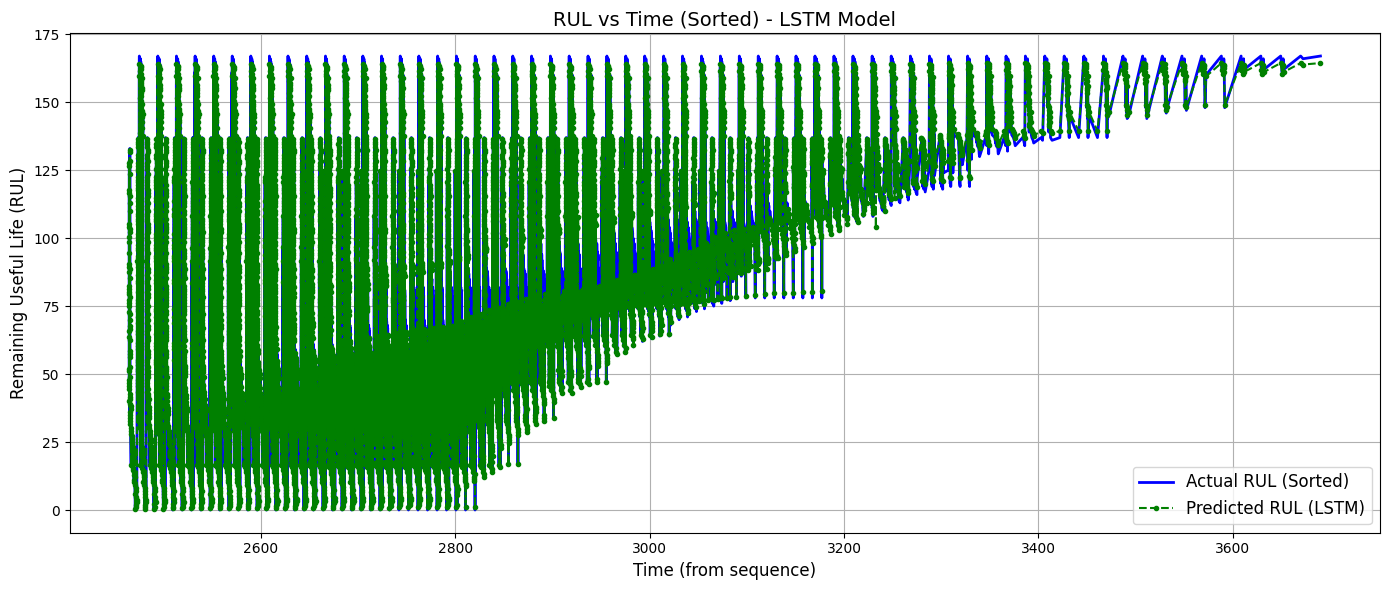

In [91]:
# Extract time and actual RUL
actual_rul = np.array(y_test).reshape(-1)
predicted_rul_lstm = lstm_preds_full_batch.reshape(-1)

# Sort by time values
sorted_indices = np.argsort(time_values)
sorted_time = time_values[sorted_indices]
sorted_actual_rul = actual_rul[sorted_indices]
sorted_predicted_rul_lstm = predicted_rul_lstm[sorted_indices]

# Plot Sorted
plt.figure(figsize=(14, 6))
plt.plot(sorted_time, sorted_actual_rul, label='Actual RUL (Sorted)', color='blue', linewidth=2)
plt.plot(sorted_time, sorted_predicted_rul_lstm, 'go--', label='Predicted RUL (LSTM)', markersize=3)

plt.title('RUL vs Time (Sorted) - LSTM Model', fontsize=14)
plt.xlabel('Time (from sequence)', fontsize=12)
plt.ylabel('Remaining Useful Life (RUL)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


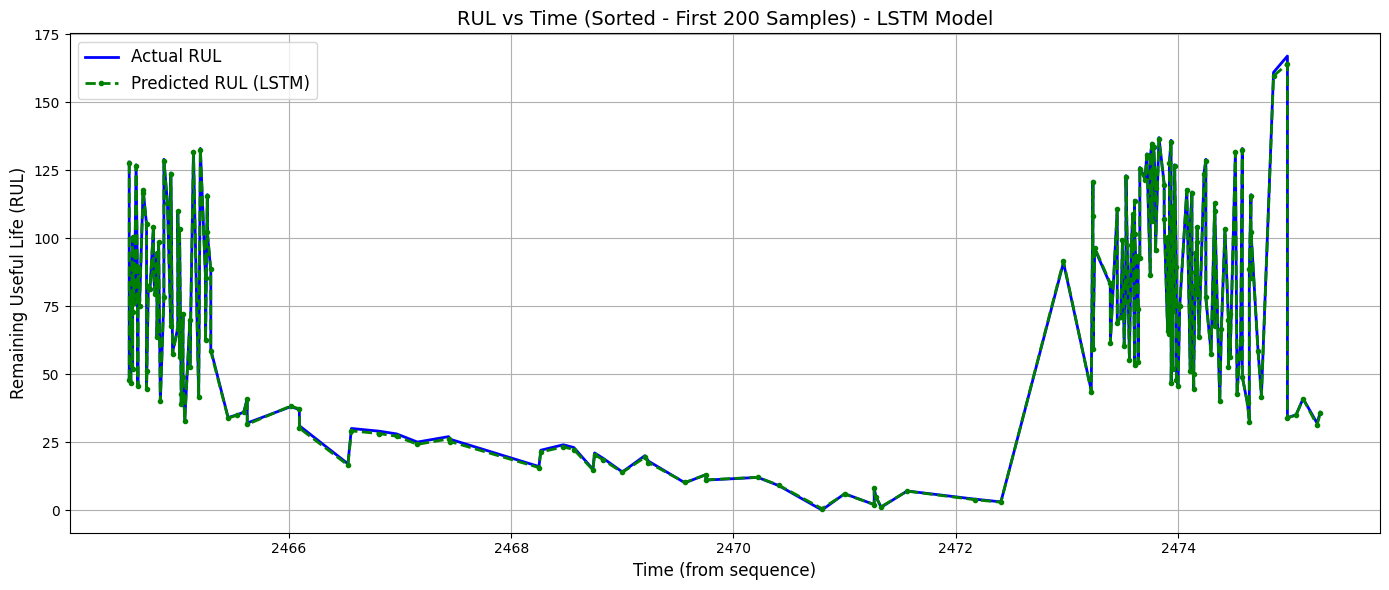

In [92]:
# Sort by time for cleaner line plots
sorted_indices = np.argsort(time_values)
sorted_time = time_values[sorted_indices]
sorted_actual_rul = actual_rul[sorted_indices]
sorted_predicted_rul_lstm = predicted_rul_lstm[sorted_indices]

# Limit samples for visualization
num_samples = 200

plt.figure(figsize=(14, 6))
plt.plot(sorted_time[:num_samples], sorted_actual_rul[:num_samples],
         label='Actual RUL', color='blue', linewidth=2)

plt.plot(sorted_time[:num_samples], sorted_predicted_rul_lstm[:num_samples],
         'go--', label='Predicted RUL (LSTM)', linewidth=2, markersize=3)

plt.title('RUL vs Time (Sorted - First 200 Samples) - LSTM Model', fontsize=14)
plt.xlabel('Time (from sequence)', fontsize=12)
plt.ylabel('Remaining Useful Life (RUL)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


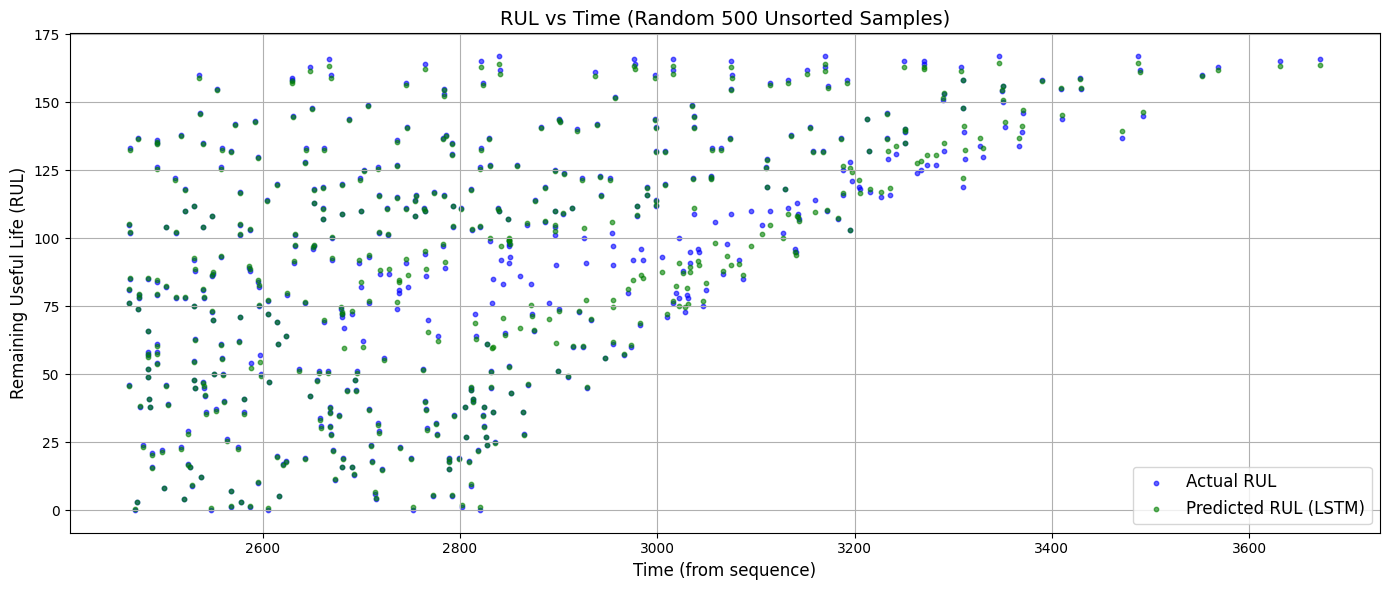

In [93]:
subset_size = 500  # Try with fewer samples
indices_subset = np.random.choice(len(time_values), size=subset_size, replace=False)

plt.figure(figsize=(14, 6))
plt.scatter(time_values[indices_subset], actual_rul[indices_subset],
            color='blue', s=10, label='Actual RUL', alpha=0.6)

predicted_rul = lstm_preds_full_batch.reshape(-1)


plt.scatter(time_values[indices_subset], predicted_rul[indices_subset],
            color='green', s=10, label='Predicted RUL (LSTM)', alpha=0.6)

plt.title(f'RUL vs Time (Random {subset_size} Unsorted Samples)', fontsize=14)
plt.xlabel('Time (from sequence)', fontsize=12)
plt.ylabel('Remaining Useful Life (RUL)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


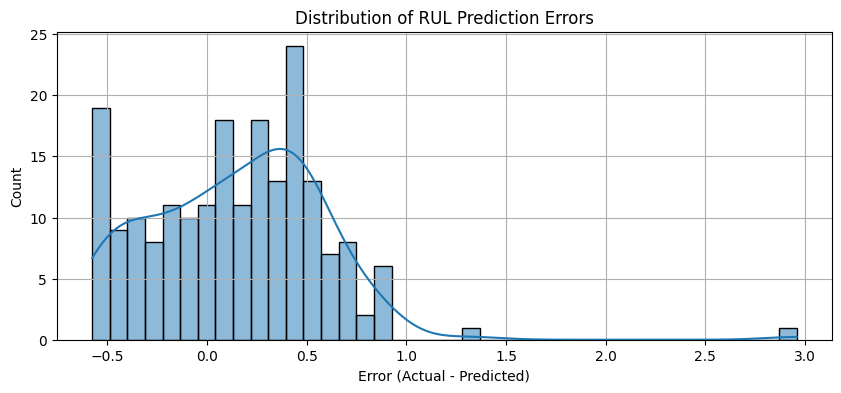

In [94]:
import seaborn as sns

errors = sorted_actual_rul[:num_samples] - sorted_predicted_rul_lstm[:num_samples].flatten()
plt.figure(figsize=(10, 4))
sns.histplot(errors, bins=40, kde=True)
plt.title("Distribution of RUL Prediction Errors")
plt.xlabel("Error (Actual - Predicted)")
plt.grid(True)
plt.show()


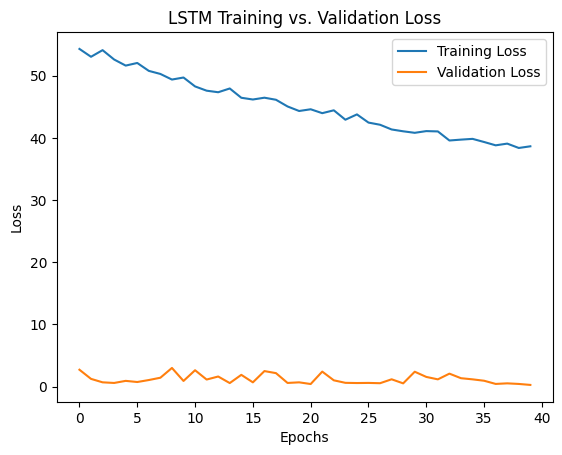

In [95]:
plot_loss(history)

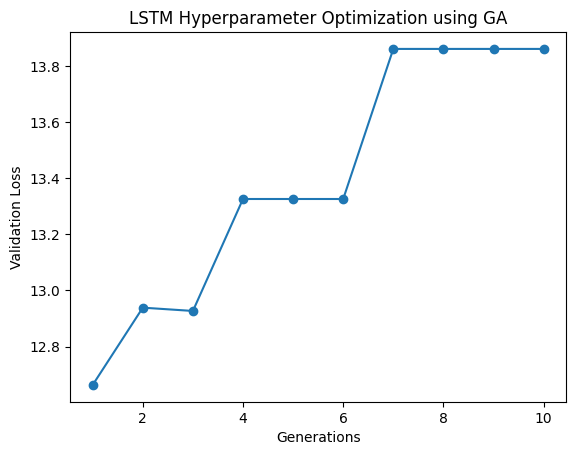

In [96]:
plot_ga_lstm_loss(loss_history)

In [136]:
svr_model=build_svr_model(X_train, X_test, y_train, y_test, mode='random')

Fitting 3 folds for each of 20 candidates, totalling 60 fits

✅ Best Params: {'gamma': 0.0005, 'epsilon': 0.15, 'C': 50}

📊 SVR Evaluation Metrics:
Train MSE : 0.0140 | Test MSE : 0.7273
Train RMSE: 0.1183 | Test RMSE: 0.8528
Train MAE : 0.0873 | Test MAE : 0.5901
Train R²  : 1.0000 | Test R²  : 0.9996
Train EVS : 1.0000 | Test EVS : 0.9998


# Train and optimize LSTM-SVR fusion using GA

In [182]:
lstm_preds, svr_preds = get_predictions(best_lstm_model, svr_model, X_test)

315/315 [==============================] - 1s 4ms/step


In [183]:
print(lstm_preds)
print(svr_preds)

[127.544495  47.729733  46.64147  ... 164.40701  163.87189  164.40558 ]
[61.57565071 61.57565071 61.57565071 ... 61.57565071 61.57565071
 61.57565071]


In [184]:
fusion_toolbox = setup_ga()

c:\Users\sarda\AppData\Local\Programs\Python\Python310\lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\sarda\AppData\Local\Programs\Python\Python310\lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [186]:
best_ind = run_ga(fusion_toolbox, lstm_preds, svr_preds, y_test)

In [187]:
print(best_ind)

[1.0]


In [188]:
print("Type of best_ind:", type(best_ind))
print("Value of best_ind:", best_ind)


Type of best_ind: <class 'deap.creator.Individual'>
Value of best_ind: [1.0]


In [201]:
# Assume best_ind is the optimized weight for LSTM
w1_opt = best_ind[0]  # Access the numerical value from the Individual object
w2_opt = 1 - w1_opt   # Remaining weight goes to SVR

# Combine predictions using weighted average
final_preds = (w1_opt * lstm_preds) + (w2_opt * svr_preds)

final_mse = mean_squared_error(y_test, final_preds)
final_rmse = np.sqrt(final_mse)
final_mae = mean_absolute_error(y_test, final_preds)
final_r2 = r2_score(y_test, final_preds)


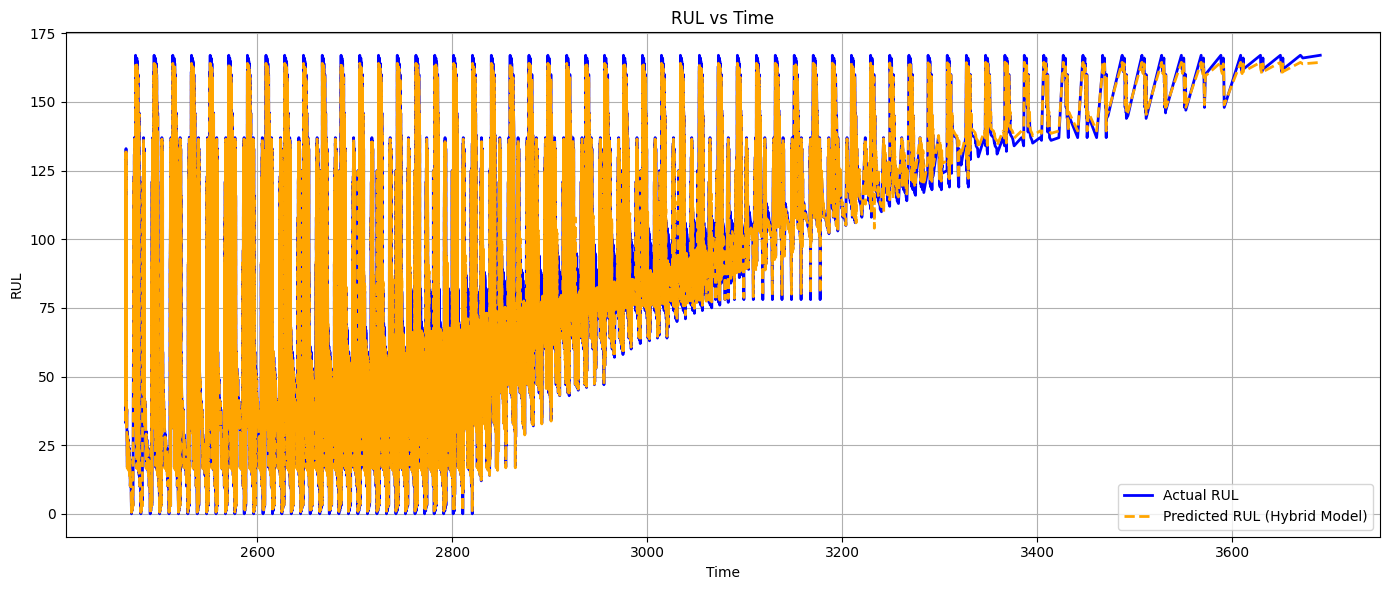

In [191]:
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1])  # remove last dimension
time_values = X_test_reshaped[:, 8]  # Index 8 is time

actual_rul = np.array(y_test).reshape(-1)
predicted_rul = np.array(final_preds).reshape(-1)

sorted_indices = np.argsort(time_values)
sorted_time = time_values[sorted_indices]
sorted_actual_rul = actual_rul[sorted_indices]
sorted_predicted_rul = predicted_rul[sorted_indices]

plt.figure(figsize=(14, 6))
plt.plot(sorted_time, sorted_actual_rul, label='Actual RUL', color='blue', linewidth=2)
plt.plot(sorted_time, sorted_predicted_rul, label='Predicted RUL (Hybrid Model)', color='orange', linestyle='--', linewidth=2)

plt.title('RUL vs Time')
plt.xlabel('Time')
plt.ylabel('RUL')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

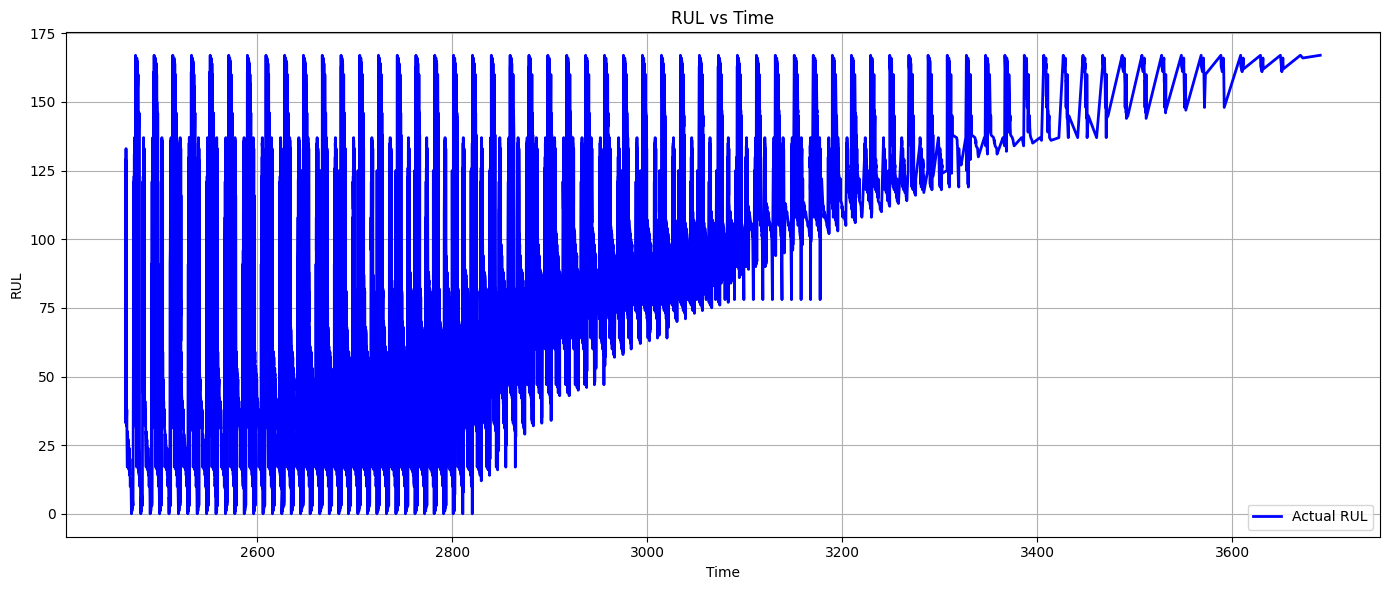

In [192]:
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1])  # remove last dimension
time_values = X_test_reshaped[:, 8]  # Index 8 is time

actual_rul = np.array(y_test).reshape(-1)
predicted_rul = np.array(final_preds).reshape(-1)

sorted_indices = np.argsort(time_values)
sorted_time = time_values[sorted_indices]
sorted_actual_rul = actual_rul[sorted_indices]
sorted_predicted_rul = predicted_rul[sorted_indices]

plt.figure(figsize=(14, 6))
plt.plot(sorted_time, sorted_actual_rul, label='Actual RUL', color='blue', linewidth=2)
# plt.plot(sorted_time, sorted_predicted_rul, label='Predicted RUL (Hybrid Model)', color='orange', linestyle='--', linewidth=2)

plt.title('RUL vs Time')
plt.xlabel('Time')
plt.ylabel('RUL')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

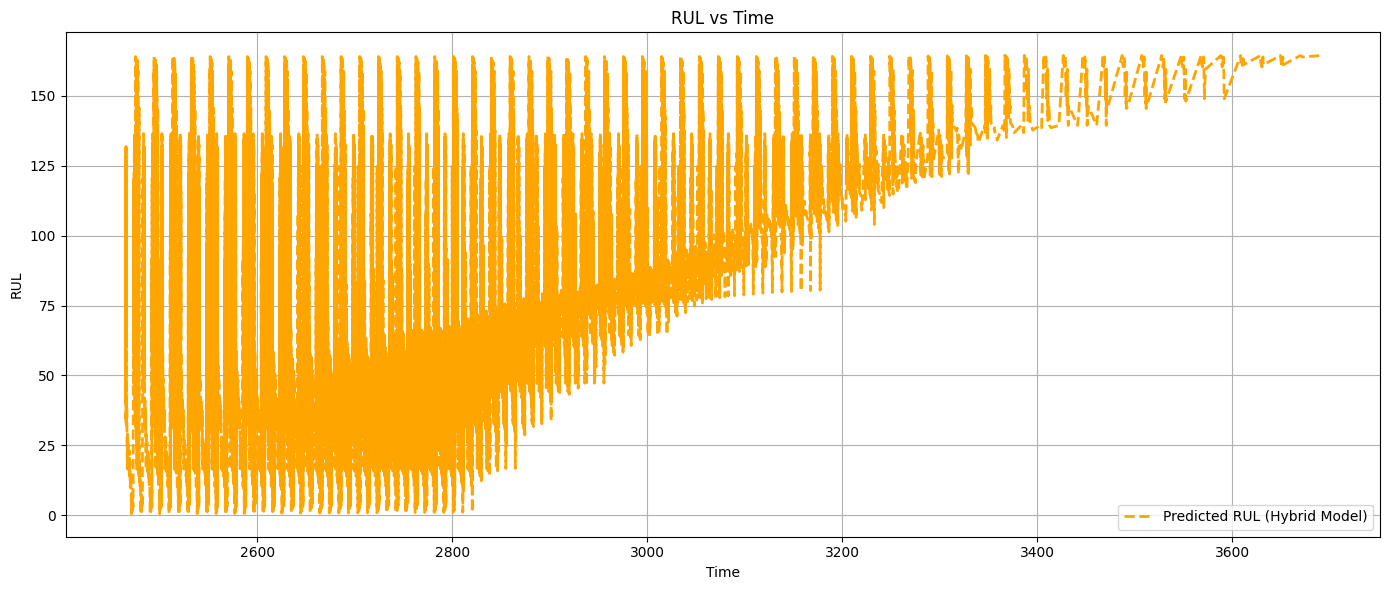

In [193]:
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1])  # remove last dimension
time_values = X_test_reshaped[:, 8]  # Index 8 is time

actual_rul = np.array(y_test).reshape(-1)
predicted_rul = np.array(final_preds).reshape(-1)

sorted_indices = np.argsort(time_values)
sorted_time = time_values[sorted_indices]
sorted_actual_rul = actual_rul[sorted_indices]
sorted_predicted_rul = predicted_rul[sorted_indices]

plt.figure(figsize=(14, 6))
# plt.plot(sorted_time, sorted_actual_rul, label='Actual RUL', color='blue', linewidth=2)
plt.plot(sorted_time, sorted_predicted_rul, label='Predicted RUL (Hybrid Model)', color='orange', linestyle='--', linewidth=2)

plt.title('RUL vs Time')
plt.xlabel('Time')
plt.ylabel('RUL')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

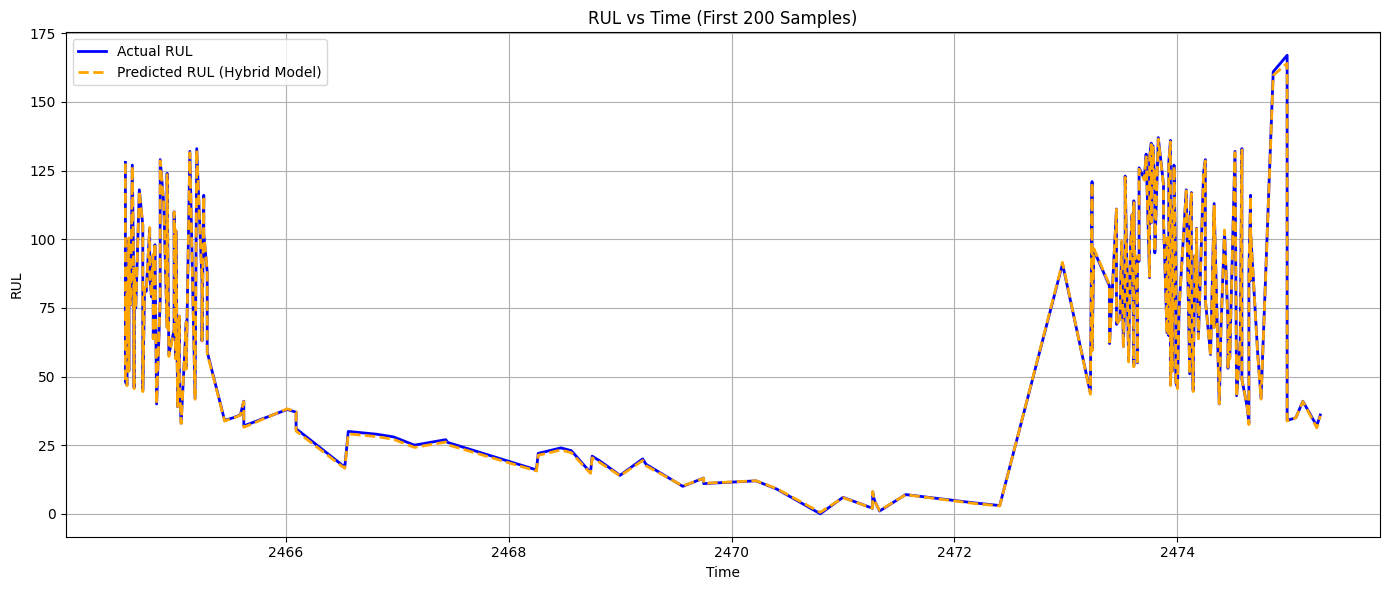

In [194]:
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1])  # remove last dimension
time_values = X_test_reshaped[:, 8]  # Index 8 is time

actual_rul = np.array(y_test).reshape(-1)
predicted_rul = np.array(final_preds).reshape(-1)

sorted_indices = np.argsort(time_values)
sorted_time = time_values[sorted_indices]
sorted_actual_rul = actual_rul[sorted_indices]
sorted_predicted_rul = predicted_rul[sorted_indices]

# Limit to first 200 sorted samples
num_samples = 200

plt.figure(figsize=(14, 6))
plt.plot(sorted_time[:num_samples], sorted_actual_rul[:num_samples], label='Actual RUL', color='blue', linewidth=2)
plt.plot(sorted_time[:num_samples], sorted_predicted_rul[:num_samples], label='Predicted RUL (Hybrid Model)', color='orange', linestyle='--', linewidth=2)

plt.title('RUL vs Time (First 200 Samples)')
plt.xlabel('Time')
plt.ylabel('RUL')   
plt.legend()
plt.grid(True)
plt.tight_layout() 
plt.show()

